# Algorithm 3 from Neal (2000)

Implementation of the algorithm 3 form Neal (2000). With a Normal-Inverse-Wishart prior. The computation of the integral is obtained from Murphy (2007) (https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_t
from scipy.stats import entropy
import random
import copy
from tqdm import tqdm
import pickle

Imports from our own code files :

In [3]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('../../main_code')))
from main_code.neal_algorithm_3 import algorithm_3, save_data, load_data
from main_code.partitions_analysis import *
from main_code.data_generation import generate_gaussian_mixture

## 1. Functions for our assumptions

Define function to compute likelihood of some observation belonging to a given cluster given our assumptions

In [3]:
# These functions change based on assumption on the prior parameters of the model
def compute_mu_0(Y):
    return np.mean(Y, axis=0)   # default to mean of data, reasonable assumption

def compute_nu_0(D):
    return D + 1    # default to D, potentially change this

def compute_inv_scale_mat_0(D):
    return np.eye(D)    # default to identity, potentially change this

def compute_lamb_0(Y):
    return 1    # default to 1, potentially change this


def integral_func_1(Y, cluster, i):
    """
    Compute the first integral using student_t distribution based on Murphy (2007) parameters
    """
    D = len(Y[0])
    mu_0 = compute_mu_0(Y)
    lamb_0 = compute_lamb_0(Y)
    nu_0 = compute_nu_0(D)
    inv_scale_mat_0 = compute_inv_scale_mat_0(D)
    n = len(cluster)    # number of element currently in cluster (used n to be consistent with Murphy (2007) notation)
    
    cluster_Y = Y[np.isin(np.arange(len(Y)),cluster)]
    cluster_mean = np.mean(cluster_Y, axis=0)

    # based on Murphy (2007). These should not be changed
    mu_n = (lamb_0 * mu_0 + n * cluster_mean) / (lamb_0 + n)
    lamb_n = lamb_0 + n
    nu_n = nu_0 + n
    
     # compute scatter matrix
    S = np.zeros((D,D))
    for j in range(n):
        temp = Y[j] - cluster_mean
        S += np.outer(temp, temp)
    temp = cluster_mean - mu_0
    inv_scale_mat_n = inv_scale_mat_0 + S + ((lamb_0 * n) / (lamb_0 + n)) * np.outer(temp, temp)

    # Computes integral using pdf of student t
    student_df = nu_n - D + 1
    integral = multivariate_t.pdf(Y[i],
                                  mu_n,
                                  inv_scale_mat_n * ((lamb_n+1) / (lamb_n * student_df)),
                                  student_df)
    return integral

def integral_func_2(Y, i):
    """
    Computes the second integral using student_t distribution based on Murphy (2007) parameters.
    """
    D = len(Y[0])
    mu_0 = compute_mu_0(Y)
    lamb_0 = compute_lamb_0(Y)
    nu_0 = compute_nu_0(D)
    inv_scale_mat_0 = compute_inv_scale_mat_0(D)
    student_df = nu_0 - D + 1
    # Computes integral using pdf of student t
    integral = multivariate_t.pdf(Y[i],
                                  mu_0,
                                  inv_scale_mat_0 * ((lamb_0 + 1) / (lamb_0 * student_df)),
                                  student_df)
    return integral

## 2. Test with synthetic data

Generate and visualize synthethic data

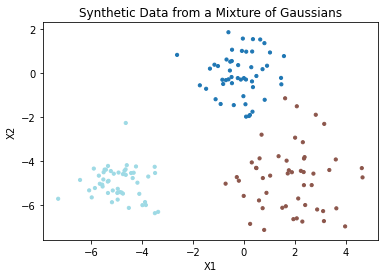

In [4]:
# Sample syntethic
np.random.seed(42)  # for reproducibility
random.seed(42)

means = [[0, 0], [2, -5], [-5, -5]]
covariances = [np.eye(2), 2 * np.eye(2), 0.5 * np.eye(2)]
n_samples = [50, 50, 50]

data, labels = generate_gaussian_mixture(means, covariances, n_samples)

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="tab20", s=10)
plt.title("Synthetic Data from a Mixture of Gaussians")
plt.xlabel("X1")
plt.ylabel("X2")
#plt.colorbar(label="Gaussian Index")
plt.show()


Apply algorithm 3 on synthetic data and visualize result

In [6]:
# these can be modified
n_steps = 5000
burn_in = 500
alpha = 1
history = algorithm_3(n_steps,
                      data,
                      integral_func_1,
                      integral_func_2,
                      alpha=alpha)

Markov Chain Progress:   0%|          | 2/5000 [00:05<4:23:24,  3.16s/step]

KeyboardInterrupt: 

Compute the similarity matix as a summary for the MCMC

In [7]:
M = sampled_sim_matrix(history[burn_in:], len(data))

Compute metrics to vizualize the evolution of the MCMC

In [8]:
entropies = list(map(compute_entropy, history))
temp = lambda x: binder_loss_list_format(x, M)
binder_losses = list(map(temp, history))

Vizualmize metrics

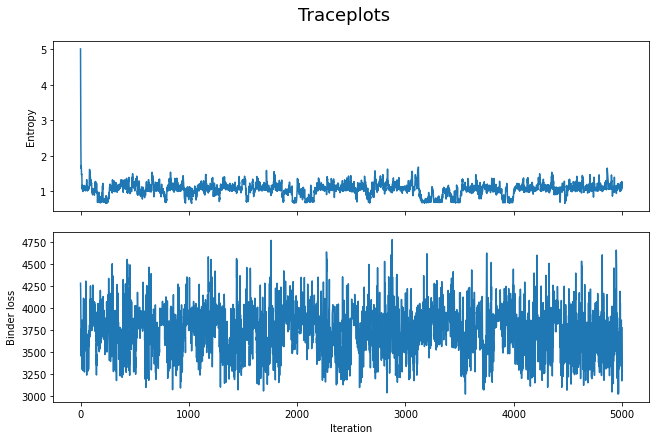

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True, )
fig.set_size_inches(9,6)
fig.suptitle('Traceplots', fontsize=18)
fig.tight_layout()
ax[0].plot(entropies)
ax[0].set_ylabel("Entropy")
ax[1].plot(binder_losses)
ax[1].set_ylabel("Binder loss")
ax[1].set_xlabel("Iteration")
plt.show()

## 3. Point estimate

Compute a point estimate as the final result of the MCMC.

/Users/eliott/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


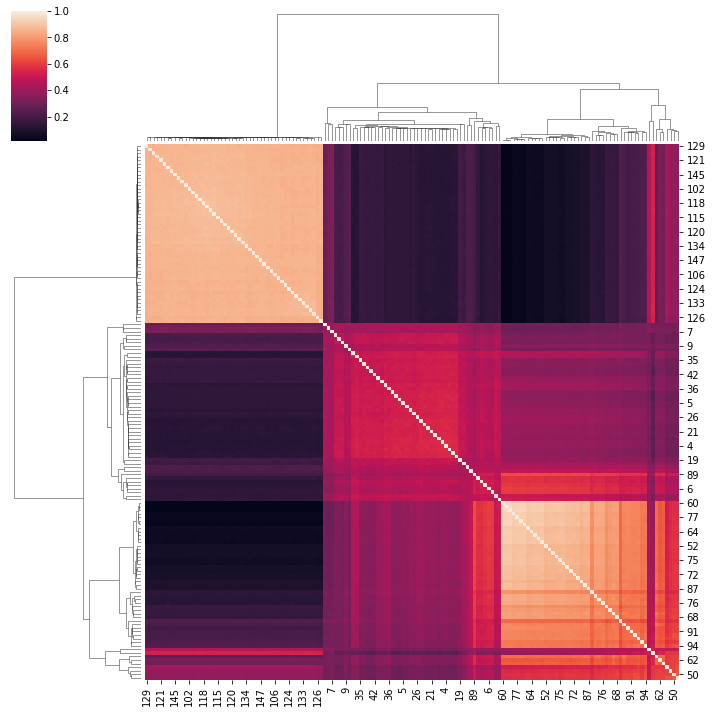

In [ ]:
sns.clustermap(M)


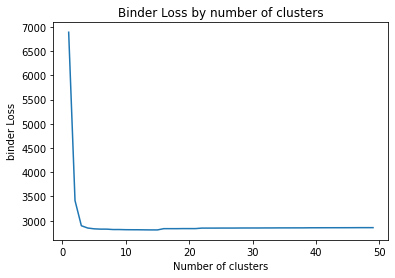

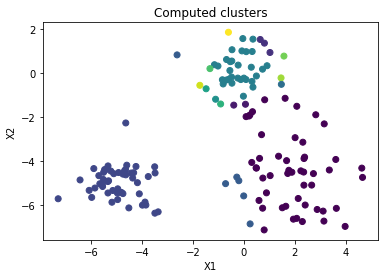

Number of clusters: 15


In [ ]:
loss = lambda x: binder_loss_label_format(x, M)
best_clustering, best_n_clusters, scores = clusters_from_matrix(M, loss)

plt.title("Binder Loss by number of clusters")
plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel("Number of clusters")
plt.ylabel("binder Loss")
plt.show()

plt.title("Computed clusters")
plt.scatter(data[:, 0], data[:, 1], c=best_clustering, cmap="tab20")
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

print(f"Number of clusters: {best_n_clusters}")


## 4. Influence of hyper-parameters

Test the influence of hyper-parameters. In particular $\alpha$ and $\lambda_0$.

### 4.1. Compute and save the MCMC for different combinaisons of hyper-parameters

In [5]:
# set the possible values of the parameters :
lambas_0 = [0.1, 1, 10]
alphas = [0.1, 1, 10]

n_steps = 5000
burn_in = 500

for lambda_0 in lambas_0:
    for alpha in alphas:

        save_path = "../../results/algorithm_3/" + f"MCMC_alpha={alpha}_lambda0={lambda_0}.MCMC_file"
        parameters = {"mu_0": "data mean",
                      "nu_0": "D + 1",
                      "inv_scale_matrix_0": "Identity",
                      "lambda_0": lambda_0,
                      "alpha": alpha}
        if os.path.isfile(save_path):
            print("Hyperparameter combinaison already has file")
            continue
        
        def compute_mu_0(Y):
            return np.mean(Y, axis=0)   # default to mean of data, reasonable assumption

        def compute_nu_0(D):
            return D + 1    # default to D, potentially change this

        def compute_inv_scale_mat_0(D):
            return np.eye(D)    # default to identity, potentially change this

        def compute_lamb_0(Y):
            return lambda_0

        def integral_func_1(Y, cluster, i):
            """
            Compute the first integral using student_t distribution based on Murphy (2007) parameters
            """
            D = len(Y[0])
            mu_0 = compute_mu_0(Y)
            lamb_0 = compute_lamb_0(Y)
            nu_0 = compute_nu_0(D)
            inv_scale_mat_0 = compute_inv_scale_mat_0(D)
            n = len(cluster)    # number of element currently in cluster (used n to be consistent with Murphy (2007) notation)
            
            cluster_Y = Y[np.isin(np.arange(len(Y)),cluster)]
            cluster_mean = np.mean(cluster_Y, axis=0)

            # based on Murphy (2007). These should not be changed
            mu_n = (lamb_0 * mu_0 + n * cluster_mean) / (lamb_0 + n)
            lamb_n = lamb_0 + n
            nu_n = nu_0 + n
            
            # compute scatter matrix
            S = np.zeros((D,D))
            for j in range(n):
                temp = Y[j] - cluster_mean
                S += np.outer(temp, temp)
            temp = cluster_mean - mu_0
            inv_scale_mat_n = inv_scale_mat_0 + S + ((lamb_0 * n) / (lamb_0 + n)) * np.outer(temp, temp)

            # Computes integral using pdf of student t
            student_df = nu_n - D + 1
            integral = multivariate_t.pdf(Y[i],
                                        mu_n,
                                        inv_scale_mat_n * ((lamb_n+1) / (lamb_n * student_df)),
                                        student_df)
            return integral

        def integral_func_2(Y, i):
            """
            Computes the second integral using student_t distribution based on Murphy (2007) parameters.
            """
            D = len(Y[0])
            mu_0 = compute_mu_0(Y)
            lamb_0 = compute_lamb_0(Y)
            nu_0 = compute_nu_0(D)
            inv_scale_mat_0 = compute_inv_scale_mat_0(D)
            student_df = nu_0 - D + 1
            # Computes integral using pdf of student t
            integral = multivariate_t.pdf(Y[i],
                                        mu_0,
                                        inv_scale_mat_0 * ((lamb_0 + 1) / (lamb_0 * student_df)),
                                        student_df)
            return integral

        history = algorithm_3(n_steps,
                            data,
                            integral_func_1,
                            integral_func_2,
                            alpha=alpha)
        
        save_data(save_path, data, labels, history, parameters)
        


Markov Chain Progress:   0%|          | 0/5000 [00:00<?, ?step/s]

Hyperparameter combinaison already has file
Hyperparameter combinaison already has file


Markov Chain Progress: 100%|██████████| 5000/5000 [30:22<00:00,  2.74step/s]


### 4.2 Compare the results

Compare the obtained point estimation

In [18]:
folder_path = "../../results/algorithm_3"

all_data_for_plots = []
burn_in = 500

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if not file_path.endswith(".MCMC_file"):  # Ensure it's a file
        continue
    data, labels, history, parameters = load_data(file_path)
    print(parameters)

    # compute quantities of interest
    M = sampled_sim_matrix(history[burn_in:], len(data))
    entropies = list(map(compute_entropy, history))
    temp = lambda x: binder_loss_list_format(x, M)
    binder_losses = list(map(temp, history))

    loss = lambda x: binder_loss_label_format(x, M)
    best_clustering, best_n_clusters, scores = clusters_from_matrix(M, loss)


    all_data_for_plots.append((data, labels, history, parameters, M, entropies, binder_losses, best_clustering, best_n_clusters, scores))


plot_data_file = folder_path + "/data_for_plots"
with open(plot_data_file, 'wb') as file:
    pickle.dump(all_data_for_plots, file)
    

{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 0.1, 'alpha': 1}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 10, 'alpha': 1}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 0.1, 'alpha': 10}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 10, 'alpha': 10}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 0.1, 'alpha': 0.1}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 1, 'alpha': 0.1}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 10, 'alpha': 0.1}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 1, 'alpha': 1}
{'mu_0': 'data mean', 'nu_0': 'D + 1', 'inv_scale_matrix_0': 'Identity', 'lambda_0': 1, 'alpha': 10}


In [9]:
folder_path = "../../results/algorithm_3"
plot_data_file = folder_path + "/data_for_plots"
with open(plot_data_file, 'wb') as file:
    pickle.dump(all_data_for_plots, file)

In [19]:
folder_path = "../../results/algorithm_3"
plot_data_file = folder_path + "/data_for_plots"
with open(plot_data_file, 'rb') as file:
    all_data_for_plots = pickle.load(file)

Plot Similarity matrices

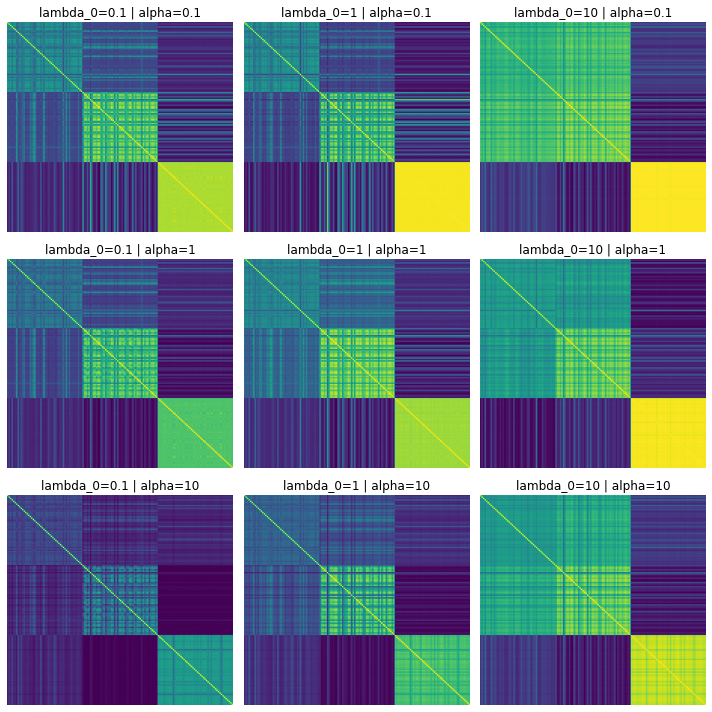

In [20]:
# code not clean but output ok
p1_values = [0.1, 1, 10]
p2_values = [0.1, 1, 10]

fig, axes = plt.subplots(len(p2_values), len(p1_values), figsize=(10, 10))

for i, p2 in enumerate(p2_values):
    for j, p1 in enumerate(p1_values):
        # Find the corresponding data
        for data, labels, history, parameters, M, entropies, binder_losses, best_clustering, best_n_clusters, scores in all_data_for_plots:
            if parameters['lambda_0'] == p1 and parameters['alpha'] == p2:
                ax = axes[i, j]
                ax.imshow(M, aspect='auto', cmap='viridis')
                ax.set_title(f"lambda_0={p1} | alpha={p2}")
                ax.axis('off')
                break
        else:
            # If no matching parameters are found
            axes[i, j].set_visible(False)

plt.tight_layout()
plt.show()


Plot obtained clusters

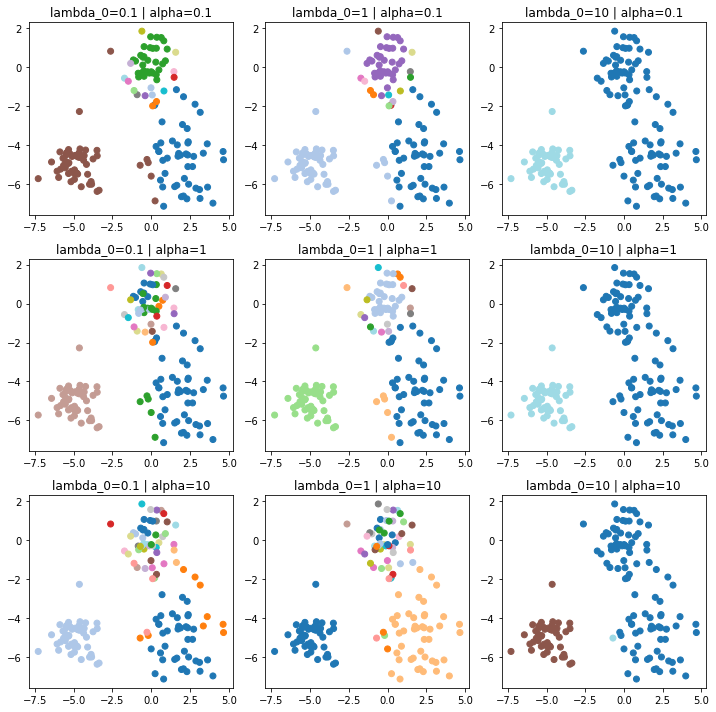

In [21]:
fig, axes = plt.subplots(len(p2_values), len(p1_values), figsize=(10, 10))

for i, p2 in enumerate(p2_values):
    for j, p1 in enumerate(p1_values):
        # Find the corresponding data
        for data, labels, history, parameters, M, entropies, binder_losses, best_clustering, best_n_clusters, scores in all_data_for_plots:
            if parameters['lambda_0'] == p1 and parameters['alpha'] == p2:
                ax = axes[i, j]
                ax.scatter(data[:, 0], data[:, 1], c=best_clustering, cmap="tab20")
                ax.set_title(f"lambda_0={p1} | alpha={p2}")
                break
        else:
            # If no matching parameters are found
            axes[i, j].set_visible(False)

plt.tight_layout()
plt.show()

Traceplots for Entropy and binder loss

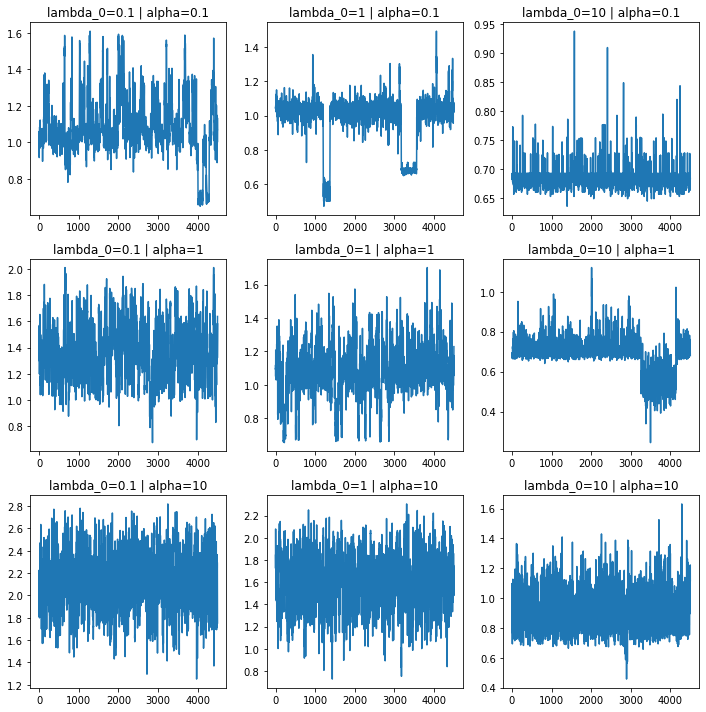

In [22]:
fig, axes = plt.subplots(len(p2_values), len(p1_values), figsize=(10, 10))

for i, p2 in enumerate(p2_values):
    for j, p1 in enumerate(p1_values):
        # Find the corresponding data
        for data, labels, history, parameters, M, entropies, binder_losses, best_clustering, best_n_clusters, scores in all_data_for_plots:
            if parameters['lambda_0'] == p1 and parameters['alpha'] == p2:
                ax = axes[i, j]
                ax.plot(entropies[burn_in:])
                ax.set_title(f"lambda_0={p1} | alpha={p2}")
                break
        else:
            # If no matching parameters are found
            axes[i, j].set_visible(False)

plt.tight_layout()
plt.show()

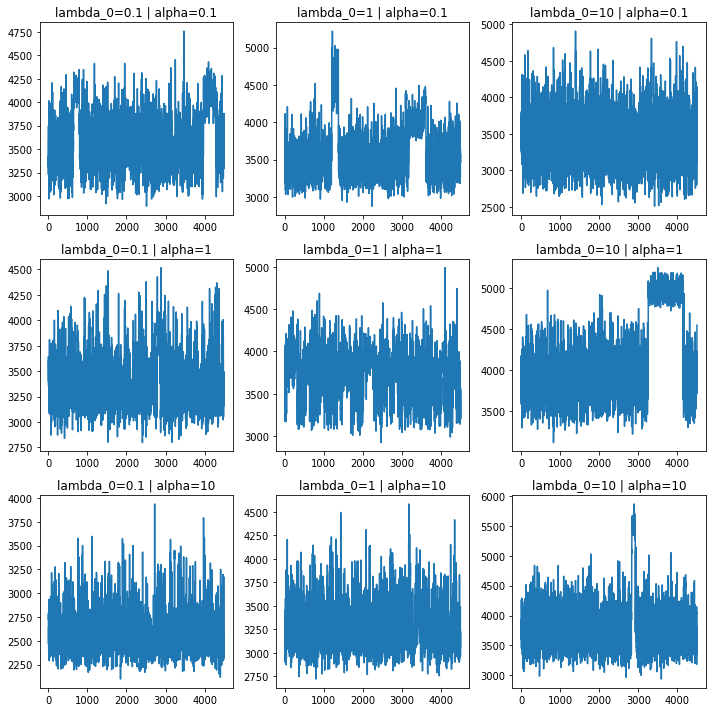

In [23]:
fig, axes = plt.subplots(len(p2_values), len(p1_values), figsize=(10, 10))

for i, p2 in enumerate(p2_values):
    for j, p1 in enumerate(p1_values):
        # Find the corresponding data
        for data, labels, history, parameters, M, entropies, binder_losses, best_clustering, best_n_clusters, scores in all_data_for_plots:
            if parameters['lambda_0'] == p1 and parameters['alpha'] == p2:
                ax = axes[i, j]
                ax.plot(binder_losses[burn_in:])
                ax.set_title(f"lambda_0={p1} | alpha={p2}")
                break
        else:
            # If no matching parameters are found
            axes[i, j].set_visible(False)

plt.tight_layout()
plt.show()